In [22]:
# This code below is to se the structure of the code for Pyramidal Neuron - Larkum style
# Learning through target spikes

import numpy as np

from lttb import LTTB

import matplotlib.pyplot as plt

from tqdm import trange
import random


N, I, O, T = 500, 5, 3, 1000
shape = (N, I, O, T)

dt = .001
tau_m = 20. * dt
tau_s = 2. * dt
tau_ro = 10. * dt
tau_star = 20. * dt
tau_W = 200 * dt


beta = np.exp(-dt/tau_s)
beta_ro = np.exp(-dt/tau_ro)
beta_targ = np.exp(-dt/tau_star)
beta_W = np.exp(-dt/tau_W)


sigma_targ = 10**1.5
sigma_in = 12.

dv = 1 / 500.
alpha = .005
alpha_rout = .01
Vo = - 4
h = - 1
s_inh = 20

sigma_Jrec = 0.
sigma_wrec = 0.
sigma_Jout = 0.1

Ne = 400
Ni = 100

N = Ne+Ni

# Here we build the dictionary of the simulation parameters
par = {'dt' : dt, 'tau_m' : tau_m, 'tau_s' : tau_s, 'tau_ro' : tau_ro, 'tau_star' : tau_star,'tau_W' : tau_W,
       'dv' : dv, 'Vo' : Vo, 'h' : h, 's_inh' : s_inh,
       'N' : N, 'Ni' : Ni, 'Ne' : Ne, 'T' : T, 'I' : I, 'O' : O, 'shape' : shape, 
       'sigma_Jrec' : sigma_Jrec,'sigma_wrec' : sigma_wrec, 'sigma_Jout' : sigma_Jout,
       'alpha' : alpha, 'alpha_rout' : alpha_rout,
       'sigma_in' : sigma_in, 'sigma_targ' : sigma_targ, 'h' : h}




TIME = 1.

T = int(np.floor(TIME/dt))

nStepOutTraining = 1000

t_shut = 10

JMAX = 100.
nu_targ = 0.005


# Here we init our (recurrent) agent
lttb = LTTB (par)


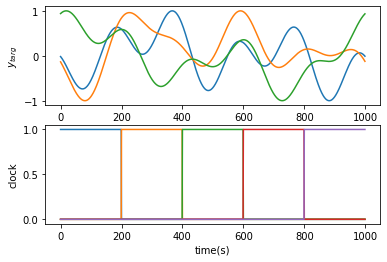

In [23]:
# define clock and target

lttb.init_targ(par)
lttb.init_clock(par)

plt.figure()
plt.subplot(211)
plt.plot(np.array(lttb.y_targ).T)
plt.ylabel('$y_{targ}$')
plt.subplot(212)
plt.plot(np.array(lttb.I_clock).T)
plt.xlabel('time(s)')
plt.ylabel('clock')
plt.show()


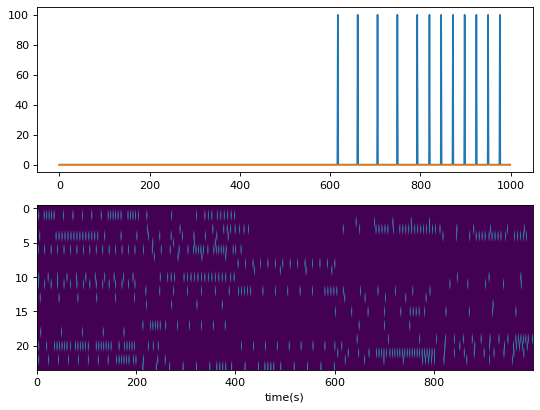

In [24]:
#initialize simulation

lttb.initialize(par)

#run simulation

for t in range(lttb.T-2):
    lttb.step(apicalFactor=1.)

#save target
S_apic_targ = lttb.S_apic_dist
    
ndx_plot = random.randint(0,lttb.N)

#plt.imshow(lttb.Vapic)
plt.figure(figsize=(8, 6), dpi=80)

plt.subplot(211)

#plt.plot(lttb.Vapic[ndx_plot,:])
#plt.plot(lttb.Vsoma[ndx_plot,:])
plt.plot(lttb.S_soma[ndx_plot,:]*100)
#plt.plot(lttb.S_wind[ndx_plot,:]*100)
plt.plot(lttb.B_filt[ndx_plot,:]*100)

plt.subplot(212)
plt.imshow(1-lttb.S_wind[1:50,:],aspect = 'auto',cmap='gray')
plt.imshow(lttb.B_filt[1:50,:],aspect = 'auto')
plt.imshow(lttb.S_soma[1:25,:],aspect = 'auto')
plt.xlabel('time(s)')

plt.show()

MATLAB code to be converted below

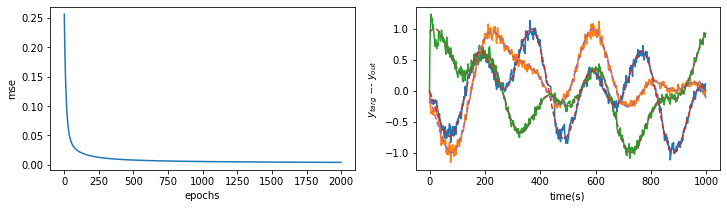

In [25]:
## Training RO

mse, Y = lttb.train_ro(par,out_epochs = 2000)

plt.figure(figsize=(12, 3))
plt.subplot(121)
plt.plot(mse)
plt.xlabel('epochs')
plt.ylabel('mse')

plt.subplot(122)
plt.plot(Y.T)
plt.plot(lttb.y_targ.T,'--')
plt.xlabel('time(s)')
plt.ylabel('$y_{targ}$ --- $y_{out}$')
plt.show()


0.05656831695915614
0.06468802107308862
0.07920300985155722
0.049411671294598156
0.04183839718428954
0.06767354019337445
0.06676621271369217
0.06341637217327781
0.06696272702450848
0.050123300934470226


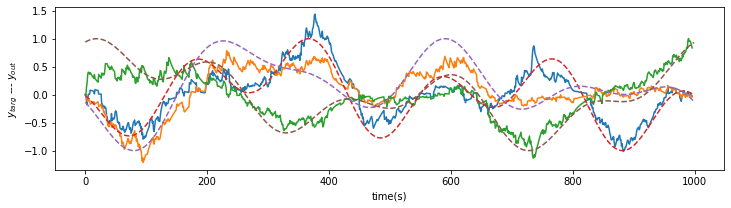

In [38]:
## Training Rec

gamma = 10.
def f(x,gamma):
    return np.exp(x*gamma)/(np.exp(x*gamma)+1)
#f1 = @(x)(gamma*exp(gamma*x))./(exp(gamma*x)+1)-(gamma*exp(2*gamma*x))./(exp(gamma*x)+1).^2;

apicalFactorTrain = 1
apicalFactorTest = 0

etaOut = 0.0
nIterRec = 10

eta = 10.
etaW = .0


for iter in range(nIterRec):
    
    ###### Online-Training

    #initialize simulation

    lttb.initialize(par)

    #run simulation
    dH = 0

    for t in range(lttb.T-2):
        
        lttb.step(apicalFactor = apicalFactorTrain)
        
        dH = dH*(1-dt/tau_m) + dt/tau_m*lttb.S_filt[:,t]
        #DJ = .2*np.outer(( lttb.B_filt[:,t+1] - lttb.B_filt_rec[:,t+1] ) ,dH)
        #DJ = np.outer(( S_apic_targ[:,t+1] - f(lttb.VapicRec[:,t],gamma) )*(1-S_apic_targ[:,t]) ,dH)
        DJ = np.outer(( lttb.S_apic_dist[:,t+1] - f(lttb.VapicRec[:,t],gamma) )*(1-S_apic_targ[:,t]) ,dH)
        lttb.J =  lttb.J + eta*DJ 
    #print(DJ)
        
    ###### Test
    
    lttb.initialize(par)

    #run simulation

    for t in range(lttb.T-2):
        
        lttb.step(apicalFactor = apicalFactorTest)
        
    SR = lttb.B_filt_rec[:,1:-2]
    Y = lttb.Jout@SR
    mse_rec_train = np.std(lttb.y_targ[:,1:-2] - Y)**2

    print(mse_rec_train)
    
#mse, Y = lttb.train_ro(par,out_epochs = 1)

plt.figure(figsize=(12, 3))
plt.plot(Y.T)
plt.plot(lttb.y_targ.T,'--')
plt.xlabel('time(s)')
plt.ylabel('$y_{targ}$ --- $y_{out}$')
plt.show()



In [18]:
(lttb.J)

array([[-2.48565536, -2.48565536, -2.48565536, ..., -2.48565536,
        -2.48565536, -2.48565536],
       [-2.48565536, -2.48565536, -2.48565536, ..., -2.48565536,
        -2.48565536, -2.48565536],
       [-2.48565536, -2.48565536, -2.48565536, ..., -2.48565536,
        -2.48565536, -2.48565536],
       ...,
       [-2.48565536, -2.48565536, -2.48565536, ..., -2.48565536,
        -2.48565536, -2.48565536],
       [-2.48565536, -2.48565536, -2.48565536, ..., -2.48565536,
        -2.48565536, -2.48565536],
       [-2.48565536, -2.48565536, -2.48565536, ..., -2.48565536,
        -2.48565536, -2.48565536]])

In [ ]:
"""

## Training Rec
for iter = 1:nIterRec
    
    
    if iter>1
        
        eta = 1.;
        
    end
    
    clear H lambda
    
    S(:,1) = zeros(N,1);
    
    Vapic = h;
    Vsoma = h;
    dH = 0;
    
    S_pred(:,1) = S(:,1);
    Ssoma(:,1) = S(:,1);
    S_wind_pred(:,1) = zeros(N,1);
    
    S_filt_apicRec(:,1) = zeros(N,1);
    
    S_filt(:,1) = S(:,1)*(1-beta);
    S_filtRO(:,1) = S(:,1)*(1-betaRO);
    S_pred_filt(:,1) = S(:,1)*(1-beta_targ);
    
    
    Vapic = h;
    VapicRec = h;
    Vsoma = h;
    
    for t = 1:T-1
        
        %%
        
        % apical rec comp
        
        VapicRec = VapicRec*(1-dt/tauH)+ dt/tauH*(J*S_filt(:,t)+  h + href  ) + VresetApic*SapicRec(:,t);
        
        % apical cont comp
        
        Vapic = Vapic*(1-dt/tauH)+ dt/tauH*( jIn*X(:,t)*apicalFactorTrain + h + href  ) + VresetApic*Sapic(:,t);
        
        % somatic comp
        
        Isoma = w*S_filt(:,t) + h + jInClock*xClock(:,t) + S_wind(:,t)*20 - b*W(:,t);%15;
        Vsoma = (Vsoma*(1-dt/tauH)+ dt/tauH*( Isoma ) ).*(1-Ssoma(:,t)) + Vreset*Ssoma(:,t)./(1 + 2*S_wind(:,t)) ;%
        
        %
        
        SapicRec(:,t+1) = Sapic_targ(:,t+1);%heaviside( f(VapicRec) - .5 );
        
        Sapic(:,t+1) =  heaviside( Vapic )  ;
        Ssoma(:,t+1) = heaviside(Vsoma  );%Ssoma_targ(:,t+1);%
%           Ssoma(:,t+1) = heaviside( f(Vsoma) - rand(size(Vsoma)));
        
        S_filt(:,t+1) = S_filt(:,t)*beta + Ssoma(:,t+1)*(1-beta);
        S_filtRO(:,t+1) = S_filtRO(:,t)*betaRO + Ssoma(:,t+1)*(1-betaRO);
        
        S_filt_soma(:,t+1) = S_filt_soma(:,t)*beta_targ + Ssoma(:,t+1)*(1-beta_targ);
        S_filt_apic(:,t+1) = S_filt_apic(:,t)*beta_targ + Sapic(:,t+1)*(1-beta_targ);
        S_filt_apicRec(:,t+1) = S_filt_apicRec(:,t)*beta_targ + SapicRec(:,t+1)*(1-beta_targ);
        
        W(:,t+1) = W(:,t)*beta_W + Ssoma(:,t+1)*(1-beta_W);
        
        %   S_wind_apic(:,t+1) = heaviside(S_filt_apic(:,t+1) - apicalThreshold);
        %   S_wind_apicCont(:,t+1) = heaviside(S_filt_apicCont(:,t+1) - apicalThreshold);
        S_wind_soma(:,t+1) = heaviside(S_filt_soma(:,t+1) - somaticThreshold);
        
        
        B(:,t+1) = S_wind_soma(:,t+1).*Sapic(:,t+1) ;
        B_rec(:,t+1) = S_wind_soma(:,t+1).*SapicRec(:,t+1) ;
        
        B_filt(:,t+1)  = B_filt(:,t)*beta_targ + B(:,t+1)*(1-beta_targ);
        B_filt_rec(:,t+1)  = B_filt_rec(:,t)*beta_targ + B_rec(:,t+1)*(1-beta_targ);
        
        S_wind_pred(:,t+1) = heaviside( B_filt_rec(:,t+1) - burstThreshold) ;
        S_wind_targ(:,t+1) = heaviside( B_filt(:,t+1) - burstThreshold) ;%S_wind_apic(:,t+1).*S_wind_soma(:,t+1);%heaviside(S_filtRO(:,t+1)-targThreshold);%.* S_wind_apic(:,t+1);
        
        %S_wind(:,t+1) = S_wind_pred(:,t+1);
        
        
        S_wind(:,t+1) = min( S_wind_pred(:,t+1)+S_wind_targ(:,t+1) ,1);
        
        V(:,t) = Vsoma;
        Vap(:,t) = Vapic;
        
        %%
        
        S_pred_filt(:,t+1) = S_pred_filt(:,t)*beta_targ + Ssoma(:,t+1)*(1-beta_targ);
        %  dH = dH*(1-dt/tauH) + dt/tauH*S_filt(:,t);
        dH = dH*(1-dt/tauH) + dt/tauH*S_pred_filt(:,t);
        
        V(:,t) = Vsoma;
        
        %%
        
        %          DJ = 50*(B_filt(:,t+1) - B_filt_rec(:,t+1)).*(1-Ssoma(:,t)).*S_wind_soma(:,t)*(dH)' ;
       % DJ = 50*(S_filt_apic(:,t+1) - S_filt_apicRec(:,t+1)).*(1-Ssoma(:,t)).*S_wind_soma(:,t)*(dH)' ;
      %DJ = (Sapic_targ(:,t+1) - SapicRec(:,t+1)).*(1-Ssoma(:,t)).*S_wind_soma(:,t)*(dH)' ;
%       DJ = heaviside(Sapic_targ(:,t+1) - f(VapicRec)).*(1-SapicRec(:,t)).*S_wind_soma(:,t+1)*(dH)' - heaviside(-Sapic_targ(:,t+1) + f(VapicRec)).*(1-SapicRec(:,t)).*(1-S_wind_soma(:,t+1))*(dH)';
 
  %  DJ = ( Sapic_targ(:,t+1) - f(VapicRec) ).*( 1-SapicRec(:,t) ).*S_wind_soma(:,t+1)*(dH)';
  
   %DJ = ( Sapic_targ(:,t+1) - f(VapicRec) ).*Sapic_targ(:,t+1).*( 1-SapicRec(:,t) ).*S_wind_soma(:,t+1)*(dH)'+  ( Sapic_targ(:,t+1) - f(VapicRec) ).*(1-Sapic_targ(:,t+1)).*( 1-SapicRec(:,t) ).*(1-S_wind_soma(:,t+1))*(dH)';
  DJ = ( Sapic_targ(:,t+1) - f(VapicRec) ).*(1-Sapic_targ(:,t))*(dH)';%+  ( Sapic_targ(:,t+1) - f(VapicRec) ).*(1-Sapic_targ(:,t+1)).*( 1-SapicRec(:,t) ).*(1-S_wind_soma(:,t+1))*(dH)';
  
    %DJ = 1000*(S_wind_targ_sv(:,t+1) - S_wind_pred(:,t+1))*(dH)';
        
        %         DJ = 50*(B_filt_targ(:,t+1) - B_filt_rec(:,t+1)).*(1-Ssoma(:,t)).*S_wind_soma(:,t)*(dH)' ;
        
        %           DJ = 50*( B_filt(:,t+1)).*(1-Ssoma(:,t)).*S_wind_soma(:,t)*(dH)' ; DJ = DJ - DJ';
        %           DJ = (S_wind_targ(:,t+1) - S_wind_pred(:,t+1)).*(1-Ssoma(:,t)).*(S_filt_soma(:,t))*(dH)' ;
        
        if sum(isnan(DJ(:)))>0
            
            'hola'
            pause(10)
            
        end
        
        DJ(ndxI,:) = 0;
        
        %%
        
        J = J+eta*(DJ );
        
        %J(:,ndxE) = max(J(:,ndxE),0);
        %J(:,ndxI) = min(J(:,ndxI),0);
        
        J(ndx_J0) = 0;
        J = J - diag(diag(J));
        
        %J = max(J,-JMAX);
        %J = min(J,JMAX);
        
        %%
        
%         SR = S_filtRO(:,t);
       
        SR = S_filtRO(:,t).*S_wind_targ(:,t);

        Y(:,t) = JRO*SR;
        %            Dw = (JRO'*(X(:,t) - Y(:,t)) ).*f1(Vsoma) *(dH.*(1-Ssoma(:,t)))' ;
        %  Dw = (S_wind_targ(:,t+1) - S_wind_pred(:,t+1)).*(1-Ssoma(:,t))*(dH)' ;
        Dw = 50*(S_filt_apic(:,t+1) - S_filt_apicRec(:,t+1)).*(1-Ssoma(:,t))*(dH)' ;
        
        
        %Dw = (S_wind_targ(:,t+1) - S_pred(:,t+1))*(dH.*(1-Ssoma(:,t)))' ;
        
        Dw(ndxI,:) = 0;
        
        w = w+etaW*(Dw );
        w(:,ndxE) = max(w(:,ndxE),0);
        w(:,ndxI) = min(w(:,ndxI),0);
        
        %%
        error(iter,t) = mean(abs(DJRO(:)));
        
    end
    
%     subplot(2,3,6)
%     imagesc(J)
%     
%     drawnow()
    %%
    
    
    %% replay
    
    
    if mod(iter,10)
        
        clear H lambda S_filtRO S_filt
        
        S(:,1) = zeros(N,1);
        S_filtRO(:,1) =  S(:,1)*(1-betaRO);
        S_filt(:,1) = S(:,1)*(1-beta);
        
        Vapic = h;
        Vsoma = h;
        
        V = ones(N,1);
        V(:,1) = Vsoma;
        
        
        Vapic = h;
        VapicRec = h;
        Vsoma = h;
        
        for t = 1:T-1
            
            
            %%
            
            
            % apical rec comp
            
            VapicRec = VapicRec*(1-dt/tauH)+ dt/tauH*(J*S_filt(:,t)+  h + href  ) + VresetApic*SapicRec(:,t);
            
            % apical cont comp
            
            Vapic = Vapic*(1-dt/tauH)+ dt/tauH*( jIn*X(:,t)*apicalFactorTest + h + href  ) + VresetApic*Sapic(:,t);
            
            % somatic comp
            
            Isoma = w*S_filt(:,t) + h + jInClock*xClock(:,t) + S_wind(:,t)*20 - b*W(:,t);%15;
            Vsoma = (Vsoma*(1-dt/tauH)+ dt/tauH*( Isoma ) ).*(1-Ssoma(:,t)) + Vreset*Ssoma(:,t)./(1 + 2*S_wind(:,t)) ;%
            
            %
            
            SapicRec(:,t+1) = heaviside( f(VapicRec) - .5 );
            
            Sapic(:,t+1) =  heaviside( f(Vapic) - .5 )  ;
            Ssoma(:,t+1) = heaviside( f(Vsoma) - .5 );
%                 Ssoma(:,t+1) = heaviside( f(Vsoma) - rand(size(Vsoma)));
                
            S_filt(:,t+1) = S_filt(:,t)*beta + Ssoma(:,t+1)*(1-beta);
            S_filtRO(:,t+1) = S_filtRO(:,t)*betaRO + Ssoma(:,t+1)*(1-betaRO);
            
            S_filt_soma(:,t+1) = S_filt_soma(:,t)*beta_targ + Ssoma(:,t+1)*(1-beta_targ);
            %   S_filt_apic(:,t+1) = S_filt_apic(:,t)*beta_targ + Sapic(:,t+1)*(1-beta_targ);
            %   S_filt_apicCont(:,t+1) = S_filt_apicCont(:,t)*beta_targ + Sapic(:,t+1)*(1-beta_targ);
            W(:,t+1) = W(:,t)*beta_W + Ssoma(:,t+1)*(1-beta_W);
            
            
            %   S_wind_apic(:,t+1) = heaviside(S_filt_apic(:,t+1) - apicalThreshold);
            %   S_wind_apicCont(:,t+1) = heaviside(S_filt_apicCont(:,t+1) - apicalThreshold);
            S_wind_soma(:,t+1) = heaviside(S_filt_soma(:,t+1) - somaticThreshold);
            
            
            B(:,t+1) = S_wind_soma(:,t+1).*Sapic(:,t+1) ;
            B_rec(:,t+1) = S_wind_soma(:,t+1).*SapicRec(:,t+1) ;
            
            B_filt(:,t+1)  = B_filt(:,t)*beta_targ + B(:,t+1)*(1-beta_targ);
            B_filt_rec(:,t+1)  = B_filt_rec(:,t)*beta_targ + B_rec(:,t+1)*(1-beta_targ);
            
            S_wind_pred(:,t+1) = heaviside( B_filt_rec(:,t+1) - burstThreshold) ;
            S_wind_targ(:,t+1) = heaviside( B_filt(:,t+1) - burstThreshold) ;%S_wind_apic(:,t+1).*S_wind_soma(:,t+1);%heaviside(S_filtRO(:,t+1)-targThreshold);%.* S_wind_apic(:,t+1);
            
            %     S_wind(:,t+1) = S_wind_pred(:,t+1);
            S_wind(:,t+1) = min( S_wind_pred(:,t+1)+S_wind_targ(:,t+1) ,1);
            
            V(:,t) = Vsoma;
            Vap(:,t) = Vapic;
            
        end
        
        %%
        
        
        SR = B_filt_rec;%S_filtRO.*S_wind_pred;
        
        X_dec2 = JRO*(SR(:,1:T-1));
        X_dec2_ = JRO*(SR(:,t0:T-1));
        
        X_ref = X(:,t0:T-1);
        mse = std(X_dec2_(:)-X_ref(:))^2;
        
        MSE(count) = mse;
        ERROR_S(count) = sum(sum(abs(S-S))/N*100);
        
        %%
        
        for k = 1:N
            
            ccc(k) = corr(S_wind(k,:)',S_wind_targ_sv(k,:)');
            %                   if isnan(ccc(k) )
            %                   ccc(k)=1;
            %                  end
            
        end
        
        correlationToTarget(count) = mean(mean(abs(S_wind-S_wind_targ_sv ))) ;%mean(ccc(find(1-isnan(ccc))));
        
        %         count = count+1;
     

    
    %% hinted - replay
    
    clear H lambda S_filtRO S_filt
    
    S(:,1) = zeros(N,1);
    S_filtRO(:,1) =  S(:,1)*(1-betaRO);
    S_filt(:,1) = S(:,1)*(1-beta);
    
    Vapic = h;
    Vsoma = h;
    
    V = ones(N,1);
    V(:,1) = Vsoma;
    
    
    Vapic = h;
    VapicRec = h;
    Vsoma = h;
    
    for t = 1:T-1
        
        
        %%
        
        
        % apical rec comp
        
        apicalFactorTestHint = 1;
        
        VapicRec = VapicRec*(1-dt/tauH)+ dt/tauH*(J*S_filt(:,t)+  h + href  ) + VresetApic*SapicRec(:,t);
        
        % apical cont comp
        
        Vapic = Vapic*(1-dt/tauH)+ dt/tauH*( jIn*X(:,t)*apicalFactorTestHint + h + href  ) + VresetApic*Sapic(:,t);
        
        % somatic comp
        
        Isoma = w*S_filt(:,t) + h + jInClock*xClock(:,t) + S_wind(:,t)*20 - b*W(:,t);%15;
        Vsoma = (Vsoma*(1-dt/tauH)+ dt/tauH*( Isoma ) ).*(1-Ssoma(:,t)) + Vreset*Ssoma(:,t)./(1 + 2*S_wind(:,t)) ;%
        
        %
        
        SapicRec(:,t+1) = heaviside( f(VapicRec) - .5 );
        
        Sapic(:,t+1) =  heaviside( f(Vapic) - .5 )  ;
        Ssoma(:,t+1) = heaviside( f(Vsoma) - .5 );
        
%             Ssoma(:,t+1) = heaviside( f(Vsoma) - rand(size(Vsoma)));
            
        S_filt(:,t+1) = S_filt(:,t)*beta + Ssoma(:,t+1)*(1-beta);
        S_filtRO(:,t+1) = S_filtRO(:,t)*betaRO + Ssoma(:,t+1)*(1-betaRO);
        
        S_filt_soma(:,t+1) = S_filt_soma(:,t)*beta_targ + Ssoma(:,t+1)*(1-beta_targ);
        %   S_filt_apic(:,t+1) = S_filt_apic(:,t)*beta_targ + Sapic(:,t+1)*(1-beta_targ);
        %   S_filt_apicCont(:,t+1) = S_filt_apicCont(:,t)*beta_targ + Sapic(:,t+1)*(1-beta_targ);
        W(:,t+1) = W(:,t)*beta_W + Ssoma(:,t+1)*(1-beta_W);
        
        
        %   S_wind_apic(:,t+1) = heaviside(S_filt_apic(:,t+1) - apicalThreshold);
        %   S_wind_apicCont(:,t+1) = heaviside(S_filt_apicCont(:,t+1) - apicalThreshold);
        S_wind_soma(:,t+1) = heaviside(S_filt_soma(:,t+1) - somaticThreshold);
        
        
        B(:,t+1) = S_wind_soma(:,t+1).*Sapic(:,t+1) ;
        B_rec(:,t+1) = S_wind_soma(:,t+1).*SapicRec(:,t+1) ;
        
        B_filt(:,t+1)  = B_filt(:,t)*beta_targ + B(:,t+1)*(1-beta_targ);
        B_filt_rec(:,t+1)  = B_filt_rec(:,t)*beta_targ + B_rec(:,t+1)*(1-beta_targ);
        
        S_wind_pred(:,t+1) = heaviside( B_filt_rec(:,t+1) - burstThreshold) ;
        S_wind_targ(:,t+1) = heaviside( B_filt(:,t+1) - burstThreshold) ;%S_wind_apic(:,t+1).*S_wind_soma(:,t+1);%heaviside(S_filtRO(:,t+1)-targThreshold);%.* S_wind_apic(:,t+1);
        
        %     S_wind(:,t+1) = S_wind_pred(:,t+1);
        S_wind(:,t+1) = min( S_wind_pred(:,t+1)+S_wind_targ(:,t+1) ,1);
        
        V(:,t) = Vsoma;
        Vap(:,t) = Vapic;
        
    end
    
    %%
    
    SR = B_filt_rec;%S_filtRO.*S_wind_pred;
        
    X_dec2 = JRO*(SR(:,1:T-1));
    X_dec2_ = JRO*(SR(:,t0:T-1));
        
    X_ref = X(:,t0:T-1);
    mse = std(X_dec2_(:)-X_ref(:))^2;
    
    MSE_hinted(count) = mse;
    ERROR_S(count) = sum(sum(abs(S-S))/N*100);
    
    %%
    
    for k = 1:N
        
        ccc(k) = corr(S_wind(k,:)',S_wind_targ_sv(k,:)');
        %                   if isnan(ccc(k) )
        %                   ccc(k)=1;
        %                  end
    end
    
    correlationToTargetHinted(count) =  mean(mean(abs(S_wind-S_wind_targ_sv )));%mean(ccc(find(1-isnan(ccc))));
    % correlationToTarget(count) = mean(mean(abs(S_wind-S_wind_targ_sv ))) ;%mean(ccc(find(1-isnan(ccc))));
       
    count = count+1;
    
    %%
    
    
    %     subplot(3,3,3)
    %     hold on
    %
    %     yyaxis left
    %     plot(correlationToTargetHinted,'--')
    %     plot(correlationToTarget)
    %
    %     ylabel('corr')
    %
    %     yyaxis right
    %     plot(MSE)
    %     plot(MSE_hinted,'--')
    %
    %     ylabel('mse')
    %     set(gca,'yscale','log')
    %
    %     legend('corr','hinted corr','mse','mse hinted')
    %     drawnow()
    %
    
    %%
    
     end
    
    figure(4)
    clf
    subplot(2,3,1)
    
    
    imagesc(S_filt_soma(1:100,:))
    %              imagesc(Ssoma(1:100,:))
    
    title('filtered spikes')
    colormap(1-gray)
    ylabel('neuron id.')
    xlabel('time (ms)')
    
    
    
    subplot(2,3,3)
    
    imagesc(S_wind_targ_sv(1:100,:))
    title('target bursts')
    colormap(1-gray)
    ylabel('neuron id.')
    xlabel('time (ms)')
    
    
    subplot(2,3,2)
    
    
    imagesc(S_wind_pred(1:100,:))
    
    title('reproduced bursts')
    colormap(1-gray)
    ylabel('neuron id.')
    set(gcf,'color','w')
    xlabel('time (ms)')
    
    
    subplot(2,3,4)
    
    hold on
    
    yyaxis left
    
    plot(correlationToTarget)
    plot(correlationToTargetHinted,'--')
    
    ylabel('corr')
    
    xlabel('n iter')
    
    
    legend('corr','hinted corr','location','southeast')
    
    
    subplot(2,3,5)
    
    
    
    hold on
    
    
    ylabel('corr')
    
    yyaxis right
    plot(MSE)
    plot(MSE_hinted,'--')
    
    ylabel('mse')
    xlabel('n iter')
    %    set(gca,'yscale','log')
    %      set(gca,'location','southeasth')
    
    legend('mse','mse hinted','location','northeast')
    
    
    drawnow()
    
    
    
end

%% entering the sequence at random time

clear H lambda S_filtRO S_filt

S(:,1) = zeros(N,1);
S_filtRO(:,1) =  S(:,1)*(1-betaRO);
S_filt(:,1) = S(:,1)*(1-beta);

Vapic = h;
Vsoma = h;

V = ones(N,1);
V(:,1) = Vsoma;


Vapic = h;
VapicRec = h;
Vsoma = h;


t_start = 500;
t_enter = 200;
t_ref = 0;

apicalFactorTestHint = 0;

for t = 1:T-1
    
    if t>t_start
        t_ref = t_start-t_enter;
    end
    
    %%
    
    if t==t_start
        apicalFactorTestHint = 0;
    end
    
    if t==t_start+50
        apicalFactorTestHint = 0;
    end
    %          apicalFactorTestHint
    %%
    
    % apical rec comp
    
    
    VapicRec = VapicRec*(1-dt/tauH)+ dt/tauH*(J*S_filt(:,t) +  h + href  ) + VresetApic*SapicRec(:,t);
    
    % apical cont comp
    
    Vapic = Vapic*(1-dt/tauH)+ dt/tauH*( jIn*X(:,t-t_ref)*apicalFactorTestHint + h + href  ) + VresetApic*Sapic(:,t);
    
    % somatic comp
    
    Isoma = w*S_filt(:,t) + h + jInClock*xClock(:,t-t_ref) + S_wind(:,t)*20 - b*W(:,t);%15;
    Vsoma = (Vsoma*(1-dt/tauH)+ dt/tauH*( Isoma ) ).*(1-Ssoma(:,t)) + Vreset*Ssoma(:,t)./(1 + 2*S_wind(:,t)) ;%
    
    %
    
    SapicRec(:,t+1) = heaviside( f(VapicRec) - .5 );
    
    Sapic(:,t+1) =  heaviside( f(Vapic) - .5 )  ;
    Ssoma(:,t+1) = heaviside( f(Vsoma) - .5 );
    
    S_filt(:,t+1) = S_filt(:,t)*beta + Ssoma(:,t+1)*(1-beta);
    S_filtRO(:,t+1) = S_filtRO(:,t)*betaRO + Ssoma(:,t+1)*(1-betaRO);
    
    S_filt_soma(:,t+1) = S_filt_soma(:,t)*beta_targ + Ssoma(:,t+1)*(1-beta_targ);
    %   S_filt_apic(:,t+1) = S_filt_apic(:,t)*beta_targ + Sapic(:,t+1)*(1-beta_targ);
    %   S_filt_apicCont(:,t+1) = S_filt_apicCont(:,t)*beta_targ + Sapic(:,t+1)*(1-beta_targ);
    W(:,t+1) = W(:,t)*beta_W + Ssoma(:,t+1)*(1-beta_W);
    
    
    %   S_wind_apic(:,t+1) = heaviside(S_filt_apic(:,t+1) - apicalThreshold);
    %   S_wind_apicCont(:,t+1) = heaviside(S_filt_apicCont(:,t+1) - apicalThreshold);
    S_wind_soma(:,t+1) = heaviside(S_filt_soma(:,t+1) - somaticThreshold);
    
    
    B(:,t+1) = S_wind_soma(:,t+1).*Sapic(:,t+1) ;
    B_rec(:,t+1) = S_wind_soma(:,t+1).*SapicRec(:,t+1) ;
    
    B_filt(:,t+1)  = B_filt(:,t)*beta_targ + B(:,t+1)*(1-beta_targ);
    B_filt_rec(:,t+1)  = B_filt_rec(:,t)*beta_targ + B_rec(:,t+1)*(1-beta_targ);
    
    S_wind_pred(:,t+1) = heaviside( B_filt_rec(:,t+1) - burstThreshold) ;
    S_wind_targ(:,t+1) = heaviside( B_filt(:,t+1) - burstThreshold) ;%S_wind_apic(:,t+1).*S_wind_soma(:,t+1);%heaviside(S_filtRO(:,t+1)-targThreshold);%.* S_wind_apic(:,t+1);
    
    %     S_wind(:,t+1) = S_wind_pred(:,t+1);
    S_wind(:,t+1) = min( S_wind_pred(:,t+1)+S_wind_targ(:,t+1) ,1);
    
    V(:,t) = Vsoma;
    Vap(:,t) = Vapic;
    
end


%%

figure
imagesc(S_wind)

%%

X_dec2 = JRO*(S_filtRO(:,1:T-1));
X_dec2_ = JRO*(S_filtRO(:,t0:T-1));

X_ref = X(:,t0:T-1);
mse = std(X_dec2_(:)-X_ref(:))^2;

MSE_hinted(count) = mse;
ERROR_S(count) = sum(sum(abs(S-S))/N*100);

%%

X_targ = X(:,t_start-t_ref+50+1:T-t_ref);
X_pred = X_dec2(:,500+50:end);

mse = std(X_pred(:)-X_targ(:))^2

%%

figure

suptitle(['mse = ' num2str(mse,2)])

subplot(3,1,1)
hold on
plot(X(1,:))
plot(X_dec2(1,:))
plot(t_start+1:T,X(1,t_start-t_ref+1:T-t_ref))


subplot(3,1,2)
set(gca,'ylim',[-1 1])
%
hold on

plot(X(2,:))
plot(X_dec2(2,:))
plot(t_start+1:T,X(2,t_start-t_ref+1:T-t_ref))

set(gca,'ylim',[-1 1])

subplot(3,1,3)
hold on
plot(X(3,:))
plot(X_dec2(3,:))
plot(t_start+1:T,X(3,t_start-t_ref+1:T-t_ref))
set(gca,'ylim',[-1 1])

set(gcf,'color','w')

%%  %% AGGIUNGERE hinted - replay

clear H lambda S_filtRO S_filt

S(:,1) = zeros(N,1);
S_filtRO(:,1) =  S(:,1)*(1-betaRO);
S_filt(:,1) = S(:,1)*(1-beta);

Vapic = h;
Vsoma = h;

V = ones(N,1);
V(:,1) = Vsoma;


Vapic = h;
VapicRec = h;
Vsoma = h;


t_start = 500;
t_enter = 200;
t_ref_0 = -500;
t_ref = t_ref_0;

apicalFactorTestHint = 1;

for t = 1:T-1
    
    if t>t_start
        t_ref = 0;
    end
    
    %          if t==t_start
    %
    %                 apicalFactorTestHint = 1;
    %          end
    
    if t== 50
        apicalFactorTestHint = 0;
    end
    %%
    
    
    % apical rec comp
    
    
    VapicRec = VapicRec*(1-dt/tauH)+ dt/tauH*(J*S_filt(:,t)+  h + href  ) + VresetApic*SapicRec(:,t);
    
    % apical cont comp
    
    Vapic = Vapic*(1-dt/tauH)+ dt/tauH*( jIn*X(:,t-t_ref)*apicalFactorTestHint + h + href  ) + VresetApic*Sapic(:,t);
    
    % somatic comp
    
    Isoma = w*S_filt(:,t) + h + jInClock*xClock(:,t-t_ref) + S_wind(:,t)*20 - b*W(:,t);%15;
    Vsoma = (Vsoma*(1-dt/tauH)+ dt/tauH*( Isoma ) ).*(1-Ssoma(:,t)) + Vreset*Ssoma(:,t)./(1 + 2*S_wind(:,t)) ;%
    
    %
    
    SapicRec(:,t+1) = heaviside( f(VapicRec) - .5 );
    
    Sapic(:,t+1) =  heaviside( f(Vapic) - .5 )  ;
    Ssoma(:,t+1) = heaviside( f(Vsoma) - .5 );
    
    S_filt(:,t+1) = S_filt(:,t)*beta + Ssoma(:,t+1)*(1-beta);
    S_filtRO(:,t+1) = S_filtRO(:,t)*betaRO + Ssoma(:,t+1)*(1-betaRO);
    
    S_filt_soma(:,t+1) = S_filt_soma(:,t)*beta_targ + Ssoma(:,t+1)*(1-beta_targ);
    %   S_filt_apic(:,t+1) = S_filt_apic(:,t)*beta_targ + Sapic(:,t+1)*(1-beta_targ);
    %   S_filt_apicCont(:,t+1) = S_filt_apicCont(:,t)*beta_targ + Sapic(:,t+1)*(1-beta_targ);
    W(:,t+1) = W(:,t)*beta_W + Ssoma(:,t+1)*(1-beta_W);
    
    
    %   S_wind_apic(:,t+1) = heaviside(S_filt_apic(:,t+1) - apicalThreshold);
    %   S_wind_apicCont(:,t+1) = heaviside(S_filt_apicCont(:,t+1) - apicalThreshold);
    S_wind_soma(:,t+1) = heaviside(S_filt_soma(:,t+1) - somaticThreshold);
    
    
    B(:,t+1) = S_wind_soma(:,t+1).*Sapic(:,t+1) ;
    B_rec(:,t+1) = S_wind_soma(:,t+1).*SapicRec(:,t+1) ;
    
    B_filt(:,t+1)  = B_filt(:,t)*beta_targ + B(:,t+1)*(1-beta_targ);
    B_filt_rec(:,t+1)  = B_filt_rec(:,t)*beta_targ + B_rec(:,t+1)*(1-beta_targ);
    
    S_wind_pred(:,t+1) = heaviside( B_filt_rec(:,t+1) - burstThreshold) ;
    S_wind_targ(:,t+1) = heaviside( B_filt(:,t+1) - burstThreshold) ;%S_wind_apic(:,t+1).*S_wind_soma(:,t+1);%heaviside(S_filtRO(:,t+1)-targThreshold);%.* S_wind_apic(:,t+1);
    
    %     S_wind(:,t+1) = S_wind_pred(:,t+1);
    S_wind(:,t+1) = min( S_wind_pred(:,t+1)+S_wind_targ(:,t+1) ,1);
    
    V(:,t) = Vsoma;
    Vap(:,t) = Vapic;
    
end


%%

X_dec2 = JRO*(S_filtRO(:,1:T-1));
X_dec2_ = JRO*(S_filtRO(:,t0:T-1));

X_ref = X(:,t0:T-1);
mse = std(X_dec2_(:)-X_ref(:))^2;

MSE_hinted(count) = mse;
ERROR_S(count) = sum(sum(abs(S-S))/N*100);

figure

subplot(3,1,1)
hold on
plot(X(1,:))
plot(X_dec2(1,:))
plot(X(1,-t_ref_0:T))


subplot(3,1,2)
set(gca,'ylim',[-1 1])
%
hold on
plot(X(2,:))
plot(X_dec2(2,:))
plot(X(2,-t_ref_0:T))

set(gca,'ylim',[-1 1])

subplot(3,1,3)
hold on
plot(X(3,:))
plot(X_dec2(3,:))
plot(X(3,-t_ref_0:T))
set(gca,'ylim',[-1 1])


%%

figure(2)
set(gcf, 'PaperUnits', 'inch', 'PaperPosition', [0 0 8 3]);
print('-deps2c', 'fastLearning.eps');

%%

ndx = randperm(N);
ndx = ndx(1);

figure(10)
clf
hold on

plot(V(ndx,:))

plot(S_wind_apic(ndx,:)*15)
plot(S_filt_soma(ndx,:)*10)

plot(jInClock(ndx,:)*xClock(:,:))
plot(jIn(ndx,:)*X(:,:))
plot(Vap(ndx,:))
plot(W(ndx,:)*b)

legend('V soma','calcio','window soma' , 'input soma' , 'input apical','V apical','W')


%%

ndx = randperm(N);
ndx = ndx(1);

figure(11)
clf
hold on
plot(S_wind_targ(ndx,:)*10)
plot(V(ndx,:))

legend('target','V(mV)')
xlabel('time (ms)')
ylabel('V (mV)')

set(gcf,'color','w')

%%


ndxNoZero = find(sum(S_wind_targ')~=0);

%%

ndx = randperm(numel(ndxNoZero));
ndxp = ndxNoZero(ndx(1));

figure(11)
clf
hold on
plot(B_filt_targ(ndxp,:)*100)
plot(B_filt(ndxp,:)*100)
plot(V(ndxp,:))

legend('target','pred','V(mV)')
xlabel('time (ms)')
ylabel('V (mV)')

set(gcf,'color','w')

%%

figure
imagesc(S)
colormap(1-gray)
xlabel('time (ms)')
ylabel('# neuron')

set(gcf,'color','w')

"""